# Simulate lateral connectivity using copy layers

* Retina = input = X
* V1 = layer V1, whose activation is H1
* V1 lateral connectivity simulation layer, excitatory E1 and inhibitary N1
* D1 is decoding layer that outputs X_bar ~-> X

## Steps

    For each sample
      Do until convergence (or n steps)
        1. E1 = previous H1
        2. N1 = negative previous H1
        3. H1 = V1(X, E1, N1)
        4. X_bar = D1(H1)
        5. Train using X_bar --> X



In [3]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
!pip install dotmap

from dotmap import DotMap
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.stats import norm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

# from google.colab import drive
# drive.mount('/content/gdrive')
# save_path_prefix = '/content/gdrive/My Drive/Colab Notebooks/saved/QDL_01'

In [0]:
def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader


def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    title = f"{title} [{image.min():.2f},{image.max():.2f}]"
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1, nrows=None, ncols=None, fig_width=30):
  s = images.shape

  assert len(s) == 3
  
  if nrows is None or ncols is None:
    resolution = int(s[0] ** 0.5)
    nrows = resolution
    ncols = resolution

  assert images.shape[0] == nrows * ncols, f"{images.shape[0]} != {nrows} * {ncols}"

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_width * nrows / ncols),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

# Creates pdf for each item
# (input_count, feature_count, height, width) => (input_count, feature_count * resolution, height, width)
def to_pdf(mu, var, resolution=10):
  mu_shape = mu.shape
  input_count, feature_count, height, width = mu_shape
  step = 1.0 / (resolution + 1)

  assert mu_shape == var.shape
  assert resolution > 0
  assert resolution < 50
  
  # mu and logvar: move features to the end and flatten
  print("to_pdf: mu", mu.shape)
  mu_combined = mu.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: mu_combined", mu_combined.shape)

  var = torch.clamp(var, step * 0.005, 3.0)
  
  var_combined = var.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: var_combined", var_combined.shape)

  # pdf for each item
  rr = np.arange(step, 1, step)
  pdfs = []
  for i in np.arange(mu_combined.shape[0]):
    pdf = norm.pdf(rr, mu_combined[i], var_combined[i])
    pdf = pdf / pdf.sum()
    pdfs.append(pdf)
  
  mu__ = torch.as_tensor(pdfs)
  print("to_pdf: mu__", mu__.shape) # (*, resolution)

  mu__ = mu__.view(-1, feature_count, resolution)
  print("to_pdf: mu__", mu__.shape) # (*, feature_count, resolution)
  
  mu__ = mu__.view(input_count, height, width, feature_count * resolution).contiguous()
  print("to_pdf: mu__", mu__.shape) # (input_count, height, width, feature_count * resolution)

  #mu__ = mu__.permute(0, 3, 1, 2).contiguous() # (input_count, feature_count * resolution, height, width)
  #print("to_pdf: mu__", mu__.shape)
  
  return mu__

# plt.plot(to_pdf(torch.tensor([[[[0.49]]]]), torch.tensor([[[[0.04]]]]), resolution=40).reshape(-1, 1).numpy())

def sample_from_pdf(pdf):
    assert pdf.shape == (resolution, )
    #print("pdf ", pdf)

    sum_pdf = sum(pdf)
    #print("sum_pdf ", sum_pdf)

    if sum_pdf > 0:
        v = random.random()
        #print("v ", v)

        s = 0
        index = 0
        while s < v and index < resolution:
          s += pdf[index] / sum_pdf
          index += 1
          #print("  s ", s)
          #print("  index ", index)
          
        # apply scale (conflates value and confidence!)
        return [(index - 1) * sum_pdf / resolution]
    else:
        return [0]


def sample_from_images__(images__):
    assert len(images__.shape) == 3

    # reshape images__ from (image count, height, width*resolution) into (image count*height*width, resolution)
    s = images__.shape
    flattened_images__ = images__.view(s[0], s[1], int(s[2] / resolution), resolution)
    s = flattened_images__.shape
    flattened_images__ = flattened_images__.view(s[0] * s[1] * s[2], s[3])

    # sample single value from each distributions into (image count*height*width, 1)
    sampled_pixels = torch.Tensor([sample_from_pdf(item.cpu().numpy()) for item in flattened_images__])

    # reshape back into (image count, height, width)
    sampled_images = sampled_pixels.view(s[0], s[1], s[2])

    return sampled_images


def averaged_sample_from_images__(images__, count=10):
    sampled_images = torch.stack([sample_from_images__(images__) for i in range(count)])
    return sampled_images.mean(dim=0)

In [0]:
# Laterally connected auto encoder
class LCAE(nn.Module):
  def __init__(self, input_shape, latent_shape):
    super(LCAE, self).__init__()
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)
    
    self.input_shape = input_shape
    self.latent_shape = latent_shape
    
    self.input_size = np.prod(input_shape)
    self.latent_size = np.prod(latent_shape)
    
    #self.e1 = nn.Linear(self.latent_size,  self.latent_size) # Excitatory
    #self.n1 = nn.Linear(self.latent_size,  self.latent_size) # iNhibitory
    self.l1 = nn.Linear(self.latent_size, self.latent_size) # Lateral
    self.init_lateral_weights()
    
    self.encoder = nn.Sequential(
      nn.Linear(self.input_size, self.latent_size * 4),
      nn.ReLU(),
      nn.Linear(self.latent_size * 4, self.latent_size * 2),
      nn.ReLU(),
      nn.Linear(self.latent_size * 2, self.latent_size),
      nn.Tanh(),
    )
    
    self.decoder = nn.Sequential(
      nn.Linear(self.latent_size, self.latent_size * 4),
      nn.ReLU(),
      nn.Linear(self.latent_size * 4, self.latent_size * 2),
      nn.ReLU(),
      nn.Linear(self.latent_size * 2, self.input_size),
      #nn.Tanh(),
    )
        
    self.dropout = nn.Dropout(0.1)
    
    self.reset()
    
  def init_lateral_weights(self):
    latent_size = self.latent_size
    mu = torch.linspace(0, 1, int(latent_size)).unsqueeze(0).unsqueeze(0).unsqueeze(0)
    var = torch.ones(mu.shape) * 0.2
    ideal_lateral_weights_exc = to_pdf(mu, var, resolution=latent_size).squeeze().float()

    var = torch.ones(mu.shape) * 0.4
    ideal_lateral_weights_inh = to_pdf(mu, var, resolution=latent_size).squeeze().float()

    ideal_lateral_weights = ideal_lateral_weights_exc - ideal_lateral_weights_inh
    ideal_lateral_weights = ideal_lateral_weights - ideal_lateral_weights.min(dim=0).values

    self.ideal_lateral_weights = ideal_lateral_weights / ideal_lateral_weights.sum(dim=0)

    
  def reset(self):
    self.h = torch.zeros(self.latent_shape)
    
  def encode(self, x):
    #e = self.e1(self.dropout(self.h))
    #n = self.n1(self.dropout(self.h))
    #l = self.l1(self.dropout(self.h))
    h = self.encoder(self.dropout(x))
    h = h @ model.ideal_lateral_weights
    
    #h = h + e - n
    #h = (h + l) / 2.0
    #h = l
    
    self.h = h

    return h

  def decode(self, h):
    x_bar = self.decoder(h)
    x_bar = torch.sigmoid(x_bar)
    return x_bar
  
  def forward(self, x):
    h = self.encode(x)
    x_bar = self.decode(h)
    
    return h, x_bar
  
def train(model, device, X, optimizer, epochs, log_interval):
  model.train()
  X = X.to(device)
  #print("X", X)
  for epoch in range(epochs):
    model.reset()
    optimizer.zero_grad()

    total_loss = 0
    
    for tick in range(1):
      qd_h, X_bar = model(X)
      #print("output", output)
      loss = F.mse_loss(X_bar, X)

      # smoothness
      #loss += (qd_h[:, 0:-1] - qd_h[:, 1:]).pow(2).mean().pow(0.5) * 0.01

      # smoothness of e1 and n1 weights
      #loss += (model.e1.weight[:, 0:-1] - model.e1.weight[:, 1:]).pow(2).mean().pow(0.5) * 0.01
      #loss += (model.n1.weight[:, 0:-1] - model.n1.weight[:, 1:]).pow(2).mean().pow(0.5) * 0.01
      
      # should sum to 1
      loss += (qd_h.sum(dim=1) - 1).pow(2).mean().pow(0.5) * 0.01

      # use all elements of resolution across samples
      use_count = qd_h.sum(dim=0)
      avg_use = use_count.mean()
      err = (use_count - avg_use).pow(2).sum().pow(0.5) / resolution
      #loss += err * 0.01

      # sparse use = values near 0.5 are discouraged. encourage more contrast, i.e
      # values near 0 and 1.
      #loss += (0.5 - (qd_h - 0.5).abs()).mean() * 0.01
      
      total_loss = loss

      if epoch % log_interval == 0:
        show_image(qd_h[0:9, :].detach(), title="qd_h", print_values=False)


    total_loss.backward()
    optimizer.step()

    if epoch % log_interval == 0:
      print(f"Epoch: {epoch} \t Tick: {tick} \t Loss: {total_loss.item():.6f}")
      show_image_grid(X_bar[0:9,:].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
      # show_image(model.e1.weight.detach(), title="e1 weights")
      # show_image(model.n1.weight.detach(), title="n1 weights")
      # show_image(model.l1.weight.detach(), title="l1 weights")

      if loss < 0.0001:
        break



to_pdf: mu torch.Size([1, 1, 1, 20])
to_pdf: mu_combined (20,)
to_pdf: var_combined (20,)
to_pdf: mu__ torch.Size([20, 20])
to_pdf: mu__ torch.Size([20, 1, 20])
to_pdf: mu__ torch.Size([1, 1, 20, 20])
to_pdf: mu torch.Size([1, 1, 1, 20])
to_pdf: mu_combined (20,)
to_pdf: var_combined (20,)
to_pdf: mu__ torch.Size([20, 20])
to_pdf: mu__ torch.Size([20, 1, 20])
to_pdf: mu__ torch.Size([1, 1, 20, 20])


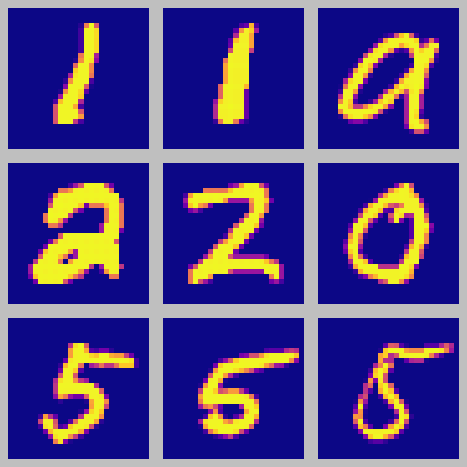

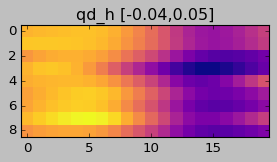

Epoch: 0 	 Tick: 0 	 Loss: 0.240666


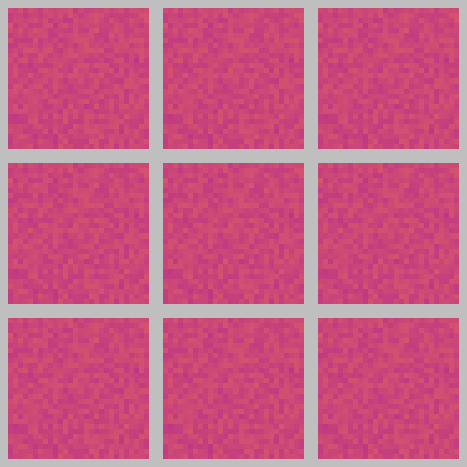

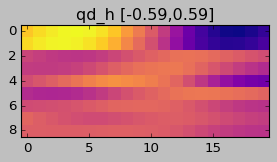

Epoch: 1000 	 Tick: 0 	 Loss: 0.041096


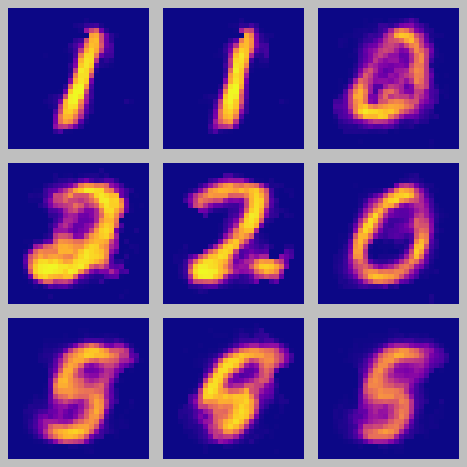

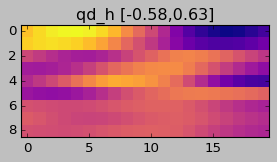

Epoch: 2000 	 Tick: 0 	 Loss: 0.033260


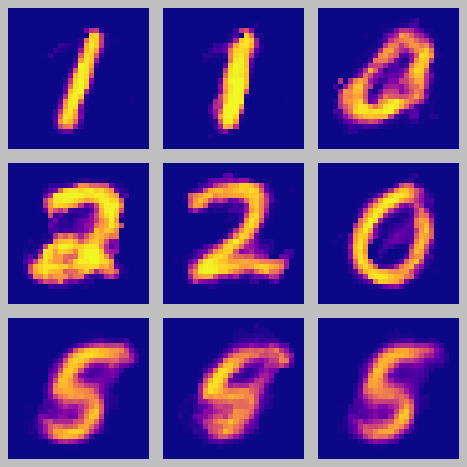

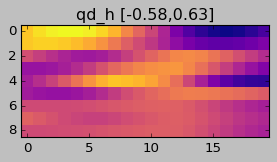

Epoch: 3000 	 Tick: 0 	 Loss: 0.029404


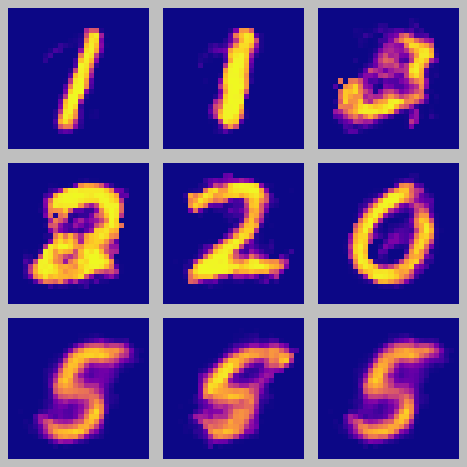

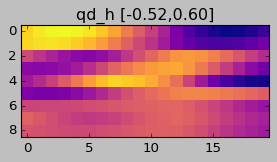

Epoch: 4000 	 Tick: 0 	 Loss: 0.027956


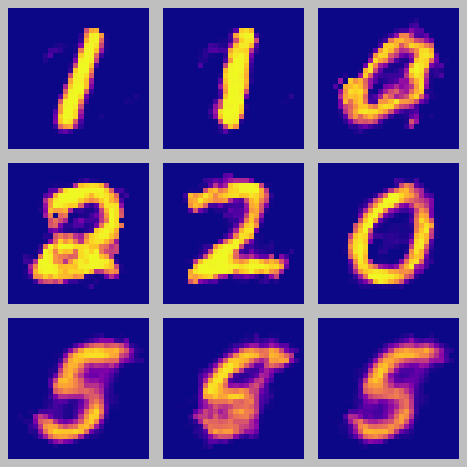

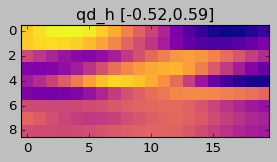

Epoch: 5000 	 Tick: 0 	 Loss: 0.026481


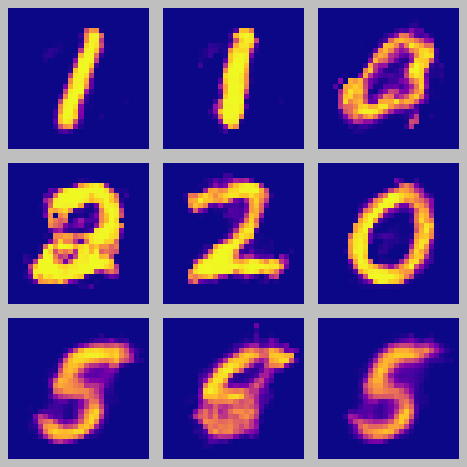

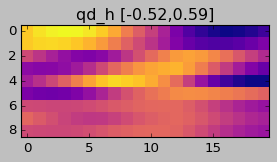

Epoch: 6000 	 Tick: 0 	 Loss: 0.025730


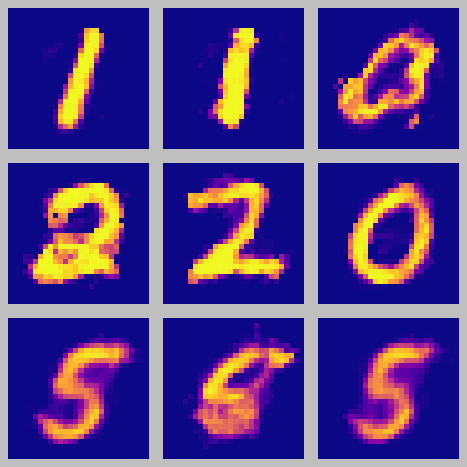

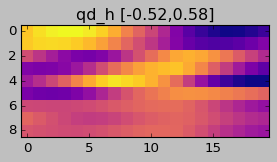

Epoch: 7000 	 Tick: 0 	 Loss: 0.025313


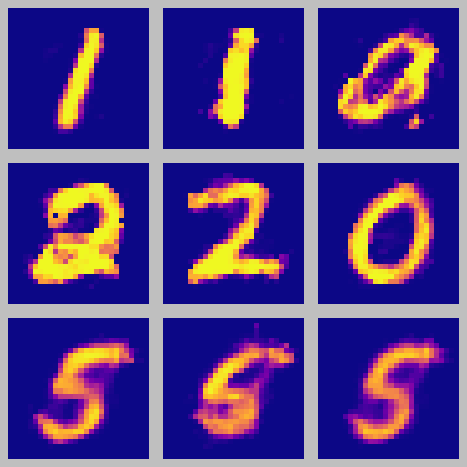

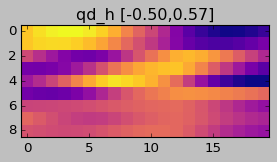

Epoch: 8000 	 Tick: 0 	 Loss: 0.024790


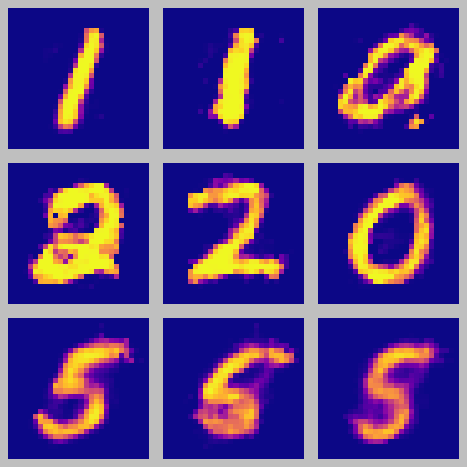

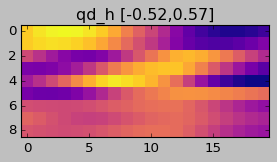

Epoch: 9000 	 Tick: 0 	 Loss: 0.024313


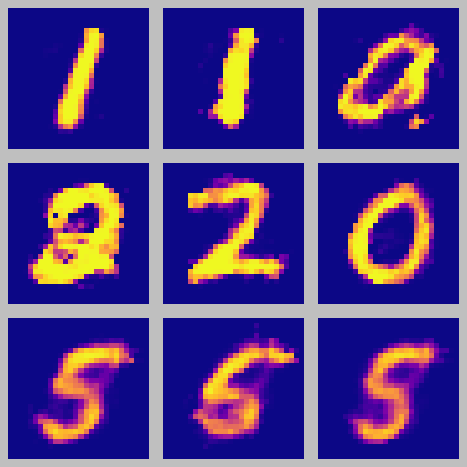

In [243]:
resolution = 20

X = next(iter(load_mnist(batch_size=500)))[0].squeeze(dim=1).view(500, -1).float()

model = LCAE(input_shape=(X.shape[-1],), latent_shape=(resolution,))

#for param in model.parameters():
    # print(type(param.data), param.size())
    #nn.init.constant(param.data, val=0.1)
    #param.data += 0.1
optimizer = optim.Adam(model.parameters(), lr=0.002)
show_image_grid(X[0:9,:].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
train(model=model, device=device, X=X, optimizer=optimizer, epochs=10000, log_interval=1000)

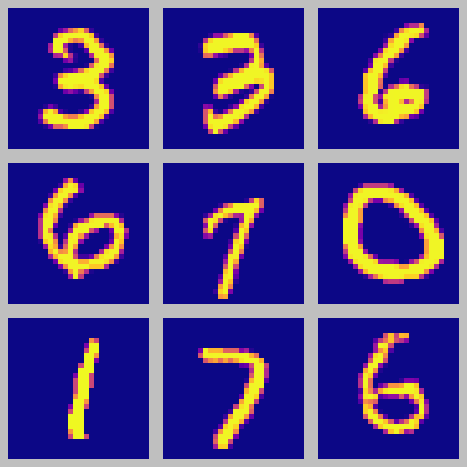

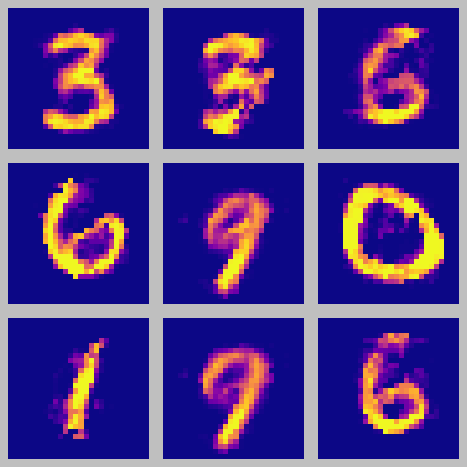

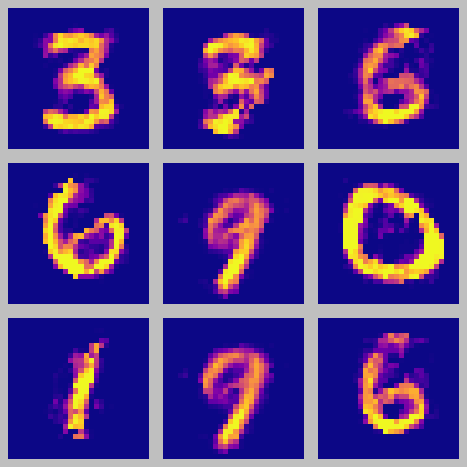

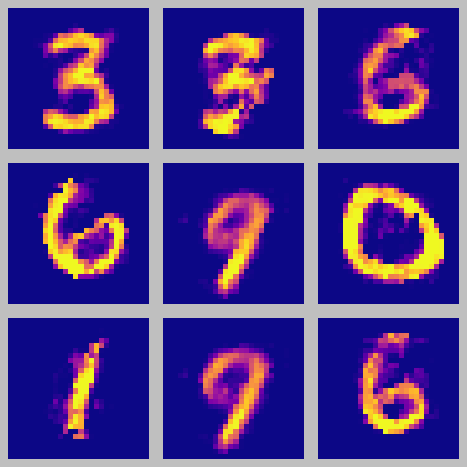

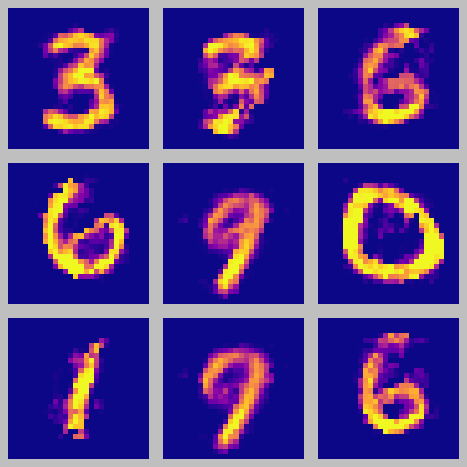

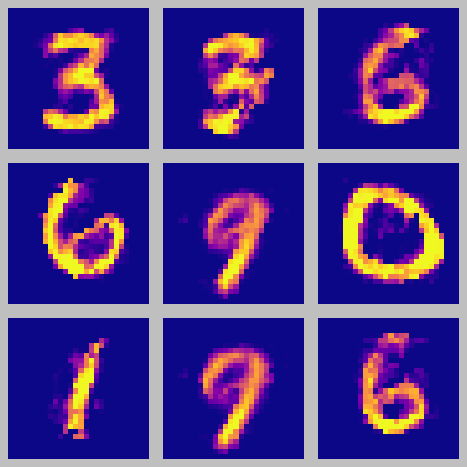

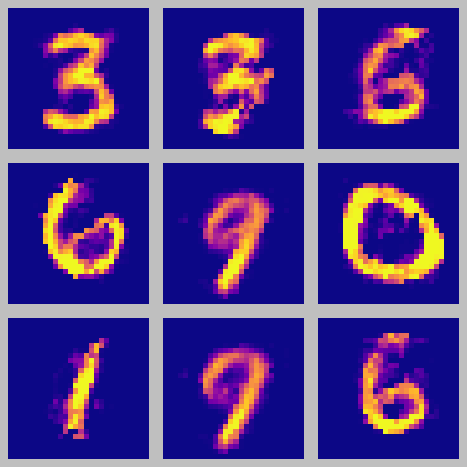

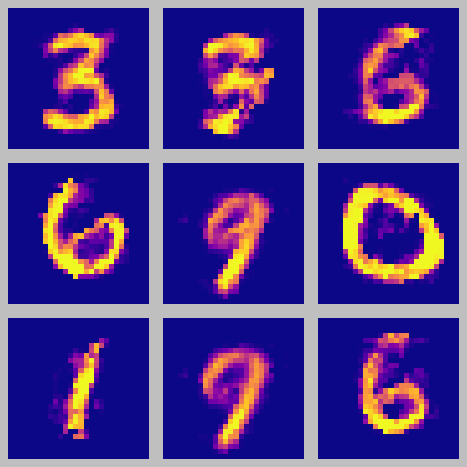

In [241]:
model.reset()
show_image_grid(X[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)
qd_h, X_bar = model(X)
show_image_grid(X_bar[0:9].view(-1,28,28), nrows=3, ncols=3, fig_width=6)